first demonstrate that the brian backend works:
bash
```sudo /opt/conda/bin/conda install cython

sudo /opt/conda/bin/pip install git+https://github.co
m/brian-team/brian2.git

```

In [ ]:

'''
Hodgkin-Huxley equations (1952).
Spikes are recorded along the axon, and then velocity is calculated.
'''
from brian2 import *
from scipy import stats

defaultclock.dt = 0.01*ms

morpho = Cylinder(length=10*cm, diameter=2*238*um, n=1000, type='axon')

El = 10.613*mV
ENa = 115*mV
EK = -12*mV
gl = 0.3*msiemens/cm**2
gNa0 = 120*msiemens/cm**2
gK = 36*msiemens/cm**2

# Typical equations
eqs = '''
# The same equations for the whole neuron, but possibly different parameter values
# distributed transmembrane current
Im = gl * (El-v) + gNa * m**3 * h * (ENa-v) + gK * n**4 * (EK-v) : amp/meter**2
I : amp (point current) # applied current
dm/dt = alpham * (1-m) - betam * m : 1
dn/dt = alphan * (1-n) - betan * n : 1
dh/dt = alphah * (1-h) - betah * h : 1
alpham = (0.1/mV) * (-v+25*mV) / (exp((-v+25*mV) / (10*mV)) - 1)/ms : Hz
betam = 4 * exp(-v/(18*mV))/ms : Hz
alphah = 0.07 * exp(-v/(20*mV))/ms : Hz
betah = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alphan = (0.01/mV) * (-v+10*mV) / (exp((-v+10*mV) / (10*mV)) - 1)/ms : Hz
betan = 0.125*exp(-v/(80*mV))/ms : Hz
gNa : siemens/meter**2
'''

neuron = SpatialNeuron(morphology=morpho, model=eqs, method="exponential_euler", 
                       refractory="m > 0.4", threshold="m > 0.5",
                       Cm=1*uF/cm**2, Ri=35.4*ohm*cm)
neuron.v = 0*mV
neuron.h = 1
neuron.m = 0
neuron.n = .5
neuron.I = 0*amp
neuron.gNa = gNa0
M = StateMonitor(neuron, 'v', record=True)
spikes = SpikeMonitor(neuron)

run(50*ms, report='text')
neuron.I[0] = 1*uA # current injection at one end
run(3*ms)
neuron.I = 0*amp
run(50*ms, report='text')

# Calculation of velocity
slope, intercept, r_value, p_value, std_err = stats.linregress(spikes.t/second,
                                                neuron.distance[spikes.i]/meter)
print("Velocity = %.2f m/s" % slope)

subplot(211)
for i in range(10):
    plot(M.t/ms, M.v.T[:, i*100]/mV)
ylabel('v')
subplot(212)
plot(spikes.t/ms, spikes.i*neuron.length[0]/cm, '.k')
plot(spikes.t/ms, (intercept+slope*(spikes.t/second))/cm, 'r')
xlabel('Time (ms)')
ylabel('Position (cm)')
show()

In [6]:
'''
http://neuromorpho.org/neuron_info.jsp?neuron_name=tc200
NeuroMorpho.Org ID :NMO_00881
Notes
-----
* Completely removed the "Fast mechanism for submembranal Ca++ concentration
  (cai)" -- it did not affect the results presented here
* Time constants for the I_T current are slightly different from the equations
  given in the paper -- the paper calculation seems to be based on 36 degree
  Celsius but the temperature that is used is 34 degrees.
* To reproduce Figure 12C, the "presence of dendritic shunt conductances" meant
  setting g_L to 0.15 mS/cm^2 for the whole neuron.
* Other small discrepancies with the paper -- values from the NEURON code were
  used whenever different from the values stated in the paper
'''

from neo import AnalogSignal
import neuronunit.capabilities.spike_functions as sf
import neuronunit.capabilities as cap
cap.ReceivesCurrent
cap.ProducesActionPotentials
from types import MethodType

def bind_NU_interface(model):

    def load_model(self):
        neuron = None
        from __future__ import print_function
        from brian2 import *

        from brian2.units.constants import (zero_celsius, faraday_constant as F,
            gas_constant as R)

        defaultclock.dt = 0.01*ms

        VT = -52*mV
        El = -76.5*mV  # from code, text says: -69.85*mV

        E_Na = 50*mV
        E_K = -100*mV
        C_d = 7.954  # dendritic correction factor

        T = 34*kelvin + zero_celsius # 34 degC (current-clamp experiments)
        tadj_HH = 3.0**((34-36)/10.0)  # temperature adjustment for Na & K (original recordings at 36 degC)
        tadj_m_T = 2.5**((34-24)/10.0)
        tadj_h_T = 2.5**((34-24)/10.0)

        shift_I_T = -1*mV

        gamma = F/(R*T)  # R=gas constant, F=Faraday constant
        Z_Ca = 2  # Valence of Calcium ions
        Ca_i = 240*nM  # intracellular Calcium concentration
        Ca_o = 2*mM  # extracellular Calcium concentration

        eqs = Equations('''
        Im = gl*(El-v) - I_Na - I_K - I_T: amp/meter**2
        I_inj : amp (point current)
        gl : siemens/meter**2
        # HH-type currents for spike initiation
        g_Na : siemens/meter**2
        g_K : siemens/meter**2
        I_Na = g_Na * m**3 * h * (v-E_Na) : amp/meter**2
        I_K = g_K * n**4 * (v-E_K) : amp/meter**2
        v2 = v - VT : volt  # shifted membrane potential (Traub convention)
        dm/dt = (0.32*(mV**-1)*(13.*mV-v2)/
                (exp((13.*mV-v2)/(4.*mV))-1.)*(1-m)-0.28*(mV**-1)*(v2-40.*mV)/
                (exp((v2-40.*mV)/(5.*mV))-1.)*m) / ms * tadj_HH: 1
        dn/dt = (0.032*(mV**-1)*(15.*mV-v2)/
                (exp((15.*mV-v2)/(5.*mV))-1.)*(1.-n)-.5*exp((10.*mV-v2)/(40.*mV))*n) / ms * tadj_HH: 1
        dh/dt = (0.128*exp((17.*mV-v2)/(18.*mV))*(1.-h)-4./(1+exp((40.*mV-v2)/(5.*mV)))*h) / ms * tadj_HH: 1
        # Low-threshold Calcium current (I_T)  -- nonlinear function of voltage
        I_T = P_Ca * m_T**2*h_T * G_Ca : amp/meter**2
        P_Ca : meter/second  # maximum Permeability to Calcium
        G_Ca = Z_Ca**2*F*v*gamma*(Ca_i - Ca_o*exp(-Z_Ca*gamma*v))/(1 - exp(-Z_Ca*gamma*v)) : coulomb/meter**3
        dm_T/dt = -(m_T - m_T_inf)/tau_m_T : 1
        dh_T/dt = -(h_T - h_T_inf)/tau_h_T : 1
        m_T_inf = 1/(1 + exp(-(v/mV + 56)/6.2)) : 1
        h_T_inf = 1/(1 + exp((v/mV + 80)/4)) : 1
        tau_m_T = (0.612 + 1.0/(exp(-(v/mV + 131)/16.7) + exp((v/mV + 15.8)/18.2))) * ms / tadj_m_T: second
        tau_h_T = (int(v<-81*mV) * exp((v/mV + 466)/66.6) +
                   int(v>=-81*mV) * (28 + exp(-(v/mV + 21)/10.5))) * ms / tadj_h_T: second
        ''')
        
        self.neuron = SpatialNeuron(morphology=morpho, model=eqs, method="exponential_euler", 
                       refractory="m > 0.4", threshold="m > 0.5",
                       Cm=1*uF/cm**2, Ri=35.4*ohm*cm)
        self.M = StateMonitor(neuron, 'v', record=True)

        



    def init_backend(self, attrs = None, cell_name= 'HH_cond_exp', current_src_name = 'hannah', DTC = None, dt=0.01):
        backend = 'HHpyNN'
        self.current_src_name = current_src_name
        self.cell_name = cell_name
        self.adexp = True

        self.DCSource = DCSource
        self.setup = setup
        self.model_path = None
        self.related_data = {}
        self.lookup = {}
        self.attrs = {}
        self.neuron = neuron
        self.model._backend = str('ExternalSim')
        self.backend = self
        self.model.attrs = {}

        #self.orig_lems_file_path = 'satisfying'
        #self.model._backend.use_memory_cache = False
        #self.model.unpicklable += ['h','ns','_backend']
        self.dt = dt
        if type(DTC) is not type(None):
            if type(DTC.attrs) is not type(None):

                self.set_attrs(**DTC.attrs)
                assert len(self.model.attrs.keys()) > 0

            if hasattr(DTC,'current_src_name'):
                self._current_src_name = DTC.current_src_name

            if hasattr(DTC,'cell_name'):
                self.cell_name = DTC.cell_name
                
        self.load_model()

    def get_membrane_potential(self):
        """Must return a neo.core.AnalogSignal.
        And must destroy the hoc vectors that comprise it.
        """
        #dt = float(copy.copy(self.neuron.dt))
        data = self.hhcell.get_data().segments[0]
        volts = data.filter(name="v")[0]#/10.0
        #data_block = all_cells.get_data()

        vm = AnalogSignal(volts,
             units = mV,
             sampling_period = self.dt *ms)
        #results['vm'] = vm
        return vm#data.filter(name="v")[0]

    def _local_run(self):
        '''
        pyNN lazy array demands a minimum population size of 3. Why is that.
        '''
        results = {}
        DURATION = 1000.0
        
        #ctx_cells.celltype.recordable
        
        
        if self.celltype == 'HH_cond_exp':

            self.hhcell.record('spikes','v')

        else:
            self.neuron.record_v(self.hhcell, "Results/HH_cond_exp_%s.v" % str(neuron))

            #self.neuron.record_gsyn(self.hhcell, "Results/HH_cond_exp_%s.gsyn" % str(neuron))
        self.neuron.run(DURATION)
        data = self.hhcell.get_data().segments[0]
        volts = data.filter(name="v")[0]#/10.0
        #data_block = all_cells.get_data()

        vm = AnalogSignal(volts,
                     units = mV,
                     sampling_period = self.dt *ms)
        results['vm'] = vm
        results['t'] = vm.times # self.times
        results['run_number'] = results.get('run_number',0) + 1
        return results




    def set_attrs(self,**attrs):                
        '''
        example params:
            neuron.v = 0*mV
            neuron.h = 1
            neuron.m = 0
            neuron.n = .5
            neuron.I = 0*amp
            neuron.gNa = gNa0
        '''
        self.init_backend()
        self.model.attrs.update(attrs)
        for k, v in attrs.items():
            exec('self.neuron.'+str(k)+'='+str(v)

        assert type(self.model.attrs) is not type(None)
        return self


    def inject_square_current(self,current):
        attrs = copy.copy(self.model.attrs)
        self.init_backend()
        self.set_attrs(**attrs)
        c = copy.copy(current)
        if 'injected_square_current' in c.keys():
            c = current['injected_square_current']

        stop = float(c['delay'])+float(c['duration'])
        duration = float(c['duration'])
        start = float(c['delay'])
        amplitude = float(c['amplitude'])
        #electrode = self.neuron.DCSource(start=start, stop=stop, amplitude=amplitude)
        self.neuron.I[0] = amplitude*uA # current injection at one end


        #electrode.inject_into(self.hhcell)
        #self.results = self._local_run()
        run(3*ms)

        self.vm = self.results['vm']
                 
                 


    def get_APs(self,vm):
        # spikes = self.M(self.neuron)

        vm = self.get_membrane_potential()
        waveforms = sf.get_spike_waveforms(vm,threshold=-45.0*mV)
        return waveforms

    def get_spike_train(self,**run_params):
        vm = self.get_membrane_potential()

        spike_train = threshold_detection(vm,threshold=-45.0*mV)

        return spike_train
    
    def get_spike_count(self,**run_params):
        vm = self.get_membrane_potential()
        return len(threshold_detection(vm,threshold=-45.0*mV))
    
    model.init_backend = MethodType(init_backend,model)
    model.get_spike_count = MethodType(get_spike_count,model)
    model.get_APs = MethodType(get_APs,model)
    model.get_spike_train = MethodType(get_spike_train,model)
    model.set_attrs = MethodType(set_attrs, model) # Bind to the score.
    model.inject_square_current = MethodType(inject_square_current, model) # Bind to the score.
    model.set_attrs = MethodType(set_attrs, model) # Bind to the score.
    model.get_membrane_potential = MethodType(get_membrane_potential,model)
    model.load_model = MethodType(load_model, model) # Bind to the score.
    model._local_run = MethodType(_local_run,model)
    model.init_backend(model)
    #model.load_model() #= MethodType(load_model, model) # Bind to the score.

    return model
HH_cond_exp = bind_NU_interface(HH_cond_exp)    
#HH_cond_exp



Starting simulation at t=0. s for a duration of 50. ms
50. ms (100%) simulated in 3s
Starting simulation at t=53. ms for a duration of 50. ms
50. ms (100%) simulated in 2s
Velocity = 12.33 m/s


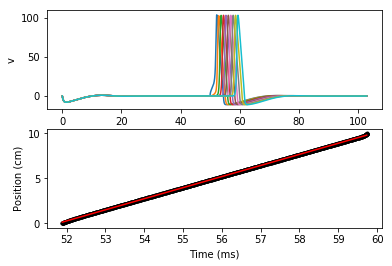

In [4]:
'''
Hodgkin-Huxley equations (1952).
Spikes are recorded along the axon, and then velocity is calculated.
'''
from brian2 import *
from scipy import stats

defaultclock.dt = 0.01*ms

morpho = Cylinder(length=10*cm, diameter=2*238*um, n=1000, type='axon')

El = 10.613*mV
ENa = 115*mV
EK = -12*mV
gl = 0.3*msiemens/cm**2
gNa0 = 120*msiemens/cm**2
gK = 36*msiemens/cm**2

# Typical equations
eqs = '''
# The same equations for the whole neuron, but possibly different parameter values
# distributed transmembrane current
Im = gl * (El-v) + gNa * m**3 * h * (ENa-v) + gK * n**4 * (EK-v) : amp/meter**2
I : amp (point current) # applied current
dm/dt = alpham * (1-m) - betam * m : 1
dn/dt = alphan * (1-n) - betan * n : 1
dh/dt = alphah * (1-h) - betah * h : 1
alpham = (0.1/mV) * (-v+25*mV) / (exp((-v+25*mV) / (10*mV)) - 1)/ms : Hz
betam = 4 * exp(-v/(18*mV))/ms : Hz
alphah = 0.07 * exp(-v/(20*mV))/ms : Hz
betah = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alphan = (0.01/mV) * (-v+10*mV) / (exp((-v+10*mV) / (10*mV)) - 1)/ms : Hz
betan = 0.125*exp(-v/(80*mV))/ms : Hz
gNa : siemens/meter**2
'''

neuron = SpatialNeuron(morphology=morpho, model=eqs, method="exponential_euler", 
                       refractory="m > 0.4", threshold="m > 0.5",
                       Cm=1*uF/cm**2, Ri=35.4*ohm*cm)
neuron.v = 0*mV
neuron.h = 1
neuron.m = 0
neuron.n = .5
neuron.I = 0*amp
neuron.gNa = gNa0
M = StateMonitor(neuron, 'v', record=True)
spikes = SpikeMonitor(neuron)

#run(50*ms, report='text')
neuron.I[0] = 1*uA # current injection at one end
run(3*ms)

#neuron.I = 0*amp
#run(50*ms, report='text')

'''
# Calculation of velocity
slope, intercept, r_value, p_value, std_err = stats.linregress(spikes.t/second,
                                                neuron.distance[spikes.i]/meter)
print("Velocity = %.2f m/s" % slope)

subplot(211)
for i in range(10):
    plot(M.t/ms, M.v.T[:, i*100]/mV)
ylabel('v')
subplot(212)
plot(spikes.t/ms, spikes.i*neuron.length[0]/cm, '.k')
plot(spikes.t/ms, (intercept+slope*(spikes.t/second))/cm, 'r')
xlabel('Time (ms)')
ylabel('Position (cm)')
show()
'''

In [1]:
from pyNN.neuron import *
from pyNN.neuron import HH_cond_exp
from pyNN.neuron import EIF_cond_exp_isfa_ista
from pyNN.neuron import Izhikevich

from pyNN import neuron
#
from pyNN.neuron import simulator as sim
from pyNN.neuron import setup as setup

from pyNN.neuron import DCSource


cryptography 2.2.1 requires asn1crypto>=0.21.0, which is not installed.
cffi 1.11.5 requires pycparser, which is not installed.
allensdk 0.14.2 has requirement pandas<0.20.0,>=0.16.2, but you'll have pandas 0.23.1 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/opt/conda/lib/python3.5/site-packages/pyNN/neuron/__init__.py:14: UserWarning: mpi4py not available
  warnings.warn("mpi4py not available")


In [2]:
import io
import math
import pdb
#from numba import jit
from contextlib import redirect_stdout
import numpy as np
#from .base import *
import quantities as qt
from quantities import mV, ms, s
import matplotlib.pyplot as plt
from pyNN.neuron import *
from pyNN.neuron import HH_cond_exp
from pyNN.neuron import EIF_cond_exp_isfa_ista
from pyNN.neuron import Izhikevich
from elephant.spike_train_generation import threshold_detection

from pyNN import neuron
#
#from pyNN.neuron import simulator as sim
from pyNN.neuron import setup as setup
#from pyNN.neuron import Izhikevich
#from pyNN.neuron import Population
from pyNN.neuron import DCSource
import numpy as np
import copy


from neo import AnalogSignal
import neuronunit.capabilities.spike_functions as sf
import neuronunit.capabilities as cap
cap.ReceivesCurrent
cap.ProducesActionPotentials
from types import MethodType

def bind_NU_interface(model):

    def load_model(self):
        neuron = None
        from pyNN import neuron
        self.hhcell = neuron.create(EIF_cond_exp_isfa_ista())
        neuron.setup(timestep=self.dt, min_delay=1.0)


    def init_backend(self, attrs = None, cell_name= 'HH_cond_exp', current_src_name = 'hannah', DTC = None, dt=0.01):
        backend = 'HHpyNN'
        self.current_src_name = current_src_name
        self.cell_name = cell_name
        self.adexp = True

        self.DCSource = DCSource
        self.setup = setup
        self.model_path = None
        self.related_data = {}
        self.lookup = {}
        self.attrs = {}
        self.neuron = neuron
        self.model._backend = str('ExternalSim')
        self.backend = self
        self.model.attrs = {}

        #self.orig_lems_file_path = 'satisfying'
        #self.model._backend.use_memory_cache = False
        #self.model.unpicklable += ['h','ns','_backend']
        self.dt = dt
        if type(DTC) is not type(None):
            if type(DTC.attrs) is not type(None):

                self.set_attrs(**DTC.attrs)
                assert len(self.model.attrs.keys()) > 0

            if hasattr(DTC,'current_src_name'):
                self._current_src_name = DTC.current_src_name

            if hasattr(DTC,'cell_name'):
                self.cell_name = DTC.cell_name
                
        self.load_model()

    def get_membrane_potential(self):
        """Must return a neo.core.AnalogSignal.
        And must destroy the hoc vectors that comprise it.
        """
        #dt = float(copy.copy(self.neuron.dt))
        data = self.hhcell.get_data().segments[0]
        volts = data.filter(name="v")[0]#/10.0
        #data_block = all_cells.get_data()

        vm = AnalogSignal(volts,
             units = mV,
             sampling_period = self.dt *ms)
        #results['vm'] = vm
        return vm#data.filter(name="v")[0]

    def _local_run(self):
        '''
        pyNN lazy array demands a minimum population size of 3. Why is that.
        '''
        results = {}
        DURATION = 1000.0
        
        #ctx_cells.celltype.recordable
        
        
        if self.celltype == 'HH_cond_exp':

            self.hhcell.record('spikes','v')

        else:
            self.neuron.record_v(self.hhcell, "Results/HH_cond_exp_%s.v" % str(neuron))

            #self.neuron.record_gsyn(self.hhcell, "Results/HH_cond_exp_%s.gsyn" % str(neuron))
        self.neuron.run(DURATION)
        data = self.hhcell.get_data().segments[0]
        volts = data.filter(name="v")[0]#/10.0
        #data_block = all_cells.get_data()

        vm = AnalogSignal(volts,
                     units = mV,
                     sampling_period = self.dt *ms)
        results['vm'] = vm
        results['t'] = vm.times # self.times
        results['run_number'] = results.get('run_number',0) + 1
        return results




    def set_attrs(self,**attrs):
        self.init_backend()
        self.model.attrs.update(attrs)
        assert type(self.model.attrs) is not type(None)
        self.hhcell[0].set_parameters(**attrs)
        return self


    def inject_square_current(self,current):
        attrs = copy.copy(self.model.attrs)
        self.init_backend()
        self.set_attrs(**attrs)
        c = copy.copy(current)
        if 'injected_square_current' in c.keys():
            c = current['injected_square_current']

        stop = float(c['delay'])+float(c['duration'])
        duration = float(c['duration'])
        start = float(c['delay'])
        amplitude = float(c['amplitude'])
        electrode = self.neuron.DCSource(start=start, stop=stop, amplitude=amplitude)


        electrode.inject_into(self.hhcell)
        self.results = self._local_run()
        self.vm = self.results['vm']

    def get_APs(self,vm):
        vm = self.get_membrane_potential()
        waveforms = sf.get_spike_waveforms(vm,threshold=-45.0*mV)
        return waveforms

    def get_spike_train(self,**run_params):
        vm = self.get_membrane_potential()

        spike_train = threshold_detection(vm,threshold=-45.0*mV)

        return spike_train
    
    def get_spike_count(self,**run_params):
        vm = self.get_membrane_potential()
        return len(threshold_detection(vm,threshold=-45.0*mV))
    
    model.init_backend = MethodType(init_backend,model)
    model.get_spike_count = MethodType(get_spike_count,model)
    model.get_APs = MethodType(get_APs,model)
    model.get_spike_train = MethodType(get_spike_train,model)
    model.set_attrs = MethodType(set_attrs, model) # Bind to the score.
    model.inject_square_current = MethodType(inject_square_current, model) # Bind to the score.
    model.set_attrs = MethodType(set_attrs, model) # Bind to the score.
    model.get_membrane_potential = MethodType(get_membrane_potential,model)
    model.load_model = MethodType(load_model, model) # Bind to the score.
    model._local_run = MethodType(_local_run,model)
    model.init_backend(model)
    #model.load_model() #= MethodType(load_model, model) # Bind to the score.

    return model
HH_cond_exp = bind_NU_interface(HH_cond_exp)    
#HH_cond_exp

In [3]:
electro_tests = []
obs_frame = {}
test_frame = {}
import os
import pickle
try: 

    electro_path = str(os.getcwd())+'all_tests.p'

    assert os.path.isfile(electro_path) == True
    with open(electro_path,'rb') as f:
        (obs_frame,test_frame) = pickle.load(f)

except:
    for p in pipe:
        p_tests, p_observations = get_neab.get_neuron_criteria(p)
        obs_frame[p["name"]] = p_observations#, p_tests))
        test_frame[p["name"]] = p_tests#, p_tests))
    electro_path = str(os.getcwd())+'all_tests.p'
    with open(electro_path,'wb') as f:
        pickle.dump((obs_frame,test_frame),f)

In [4]:
use_test = test_frame["Neocortex pyramidal cell layer 5-6"]
use_test[0].observation
#from neuronunit.tests import RheobaseP
from neuronunit.tests.fi import RheobaseTest# as discovery

rtp = RheobaseTest(use_test[0].observation)
use_test[0] = rtp


HH_cond_exp.attrs = HH_cond_exp.simple_parameters(HH_cond_exp)
#print(HH_cond_exp.attrs)
HH_cond_exp.scaled_parameters(HH_cond_exp)
dir(HH_cond_exp)
HH_cond_exp.default_initial_values
HH_cond_exp.attrs
NGEN = 10
MU = 10
from neuronunit.optimization import optimization_management as om
explore_ranges = {'e_rev_Na' : (40,70), 'e_rev_K': (-90.0,-75.0), 'cm' : (0.25,1.5)}
npcl, DO = om.run_ga(explore_ranges,NGEN,use_test,free_params=explore_ranges.keys(), NSGA = True, MU = MU,model_type=None)

#hc = 

NameError: name 'test_frame' is not defined

In [ ]:
#dir(HH_cond_exp)
#HH_cond_exp.get_parameters()
#hhcell[0].get_parameters()
#dir(HH_cond_exp)
HH_cond_exp.attrs = HH_cond_exp.simple_parameters(HH_cond_exp)
HH_cond_exp.celltype = HH_cond_exp
iparams = {}
iparams['injected_square_current'] = {}
#iparams['injected_square_current']['amplitude'] = 1.98156805*pq.pA
iparams['injected_square_current']['amplitude'] = 0.68156805*pq.pA

DELAY = 100.0*pq.ms
DURATION = 1000.0*pq.ms
iparams['injected_square_current']['delay'] = DELAY
iparams['injected_square_current']['duration'] = int(DURATION)

HH_cond_exp.inject_square_current(iparams)
print(HH_cond_exp.get_spike_count())

print(HH_cond_exp.vm)

import matplotlib.pyplot as plt
plt.plot(HH_cond_exp.vm.times,HH_cond_exp.vm)


plt.show()
iparams['injected_square_current']['amplitude'] = 0.8598156805*pq.pA
#iparams['injected_square_current']['amplitude'] = 2000.98156805*pq.pA

DELAY = 100.0*pq.ms
DURATION = 1000.0*pq.ms
iparams['injected_square_current']['delay'] = DELAY
iparams['injected_square_current']['duration'] = int(DURATION)

HH_cond_exp.inject_square_current(iparams)
print(HH_cond_exp.get_spike_count())
import matplotlib.pyplot as plt
plt.plot(HH_cond_exp.vm.times,HH_cond_exp.vm)

plt.show()
pred = use_test[0].generate_prediction(HH_cond_exp)


In [ ]:
#dir(HH_cond_exp)

In [ ]:
print(pred)

In [ ]:
iparams['injected_square_current']['amplitude'] = pred['value']
#iparams['injected_square_current']['amplitude'] = 2000.98156805*pq.pA

DELAY = 100.0*pq.ms
DURATION = 1000.0*pq.ms
iparams['injected_square_current']['delay'] = DELAY
iparams['injected_square_current']['duration'] = int(DURATION)

HH_cond_exp.inject_square_current(iparams)
print(HH_cond_exp.get_spike_count())
import matplotlib.pyplot as plt
plt.plot(HH_cond_exp.vm.times,HH_cond_exp.vm)


In [ ]:

import pyNN
from pyNN import neuron
from pyNN.neuron import EIF_cond_exp_isfa_ista
#neurons = pyNN.Population(N_CX, pyNN.EIF_cond_exp_isfa_ista, RS_parameters)

cell = neuron.create(EIF_cond_exp_isfa_ista())
#cell[0].set_parameters(**LTS_parameters)
cell[0].get_parameters()

In [ ]:


explore_ranges = {'E_Na' : (40,70), 'E_K': (-90.0,-75.0), 'C_m' : (0.25,1.5), 'g_K':(30,40), 'g_Na':(100,140), 'g_L':(0.1,0.5), 'E_L':(-60.0,-45)}

attrs = { 'g_K' : 36.0, 'g_Na' : 120.0, 'g_L' : 0.3, \
         'C_m' : 1.0, 'E_L' : -54.387, 'E_K' : -77.0, 'E_Na' : 50.0, 'vr':-65.0 } 

    
from neuronunit.optimization import optimization_management as om
print(test_frame)    
MU = 12
NGEN = 25
cnt = 1
#hc = { 'g_L' : 0.3, 'E_L' : -54.387,
hc = {'vr':-65.0 } 

#npcl, DO = om.run_g
npcl, DO = om.run_ga(explore_ranges,NGEN,use_test,free_params=explore_ranges.keys(), hc = hc, NSGA = True, MU = MU,model_type='HH')
    